In [2]:
import numpy as np 
import tensorflow as tf 
import os 
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
import random


In [102]:
# Define the content and style image path 
content_path = '/kaggle/input/image-classification/validation/validation/travel and adventure/13.jpg'

style_path = '/kaggle/input/best-artworks-of-all-time/images/images/'
# Select a random artist from the style dataset 
artist = random.choice(os.listdir(style_path))
print('Artist chosen:', artist)

# Update the style path 
style_path = os.path.join(style_path, artist)

Artist chosen: Piet_Mondrian


In [103]:
def preprocess_image(image, expand_dims = True): 
    # Convert the image into numpy array 
    img_array = img_to_array(image)
    
    # Make the image 4 dimensional
    if expand_dims is True: img_array = np.expand_dims(img_array, axis=0)
        
    # Preprocess the image for VGG model 
    img_array = img_array/255
    
    return img_array

In [104]:
def load_dataset(dataset_path, target_size, limit = None):
    images = [] 
    for dirname, _, filenames in os.walk(dataset_path): 
        # Choose the specified number of files randomly 
        if limit is not None: 
            filenames = random.sample(filenames, limit)
        for filename in filenames: 
            # Load the image 
            img = load_img(os.path.join(dirname, filename), target_size=target_size)
            img_array = preprocess_image(img, expand_dims=True)
            images.append(img_array)
    images = np.array(images)
    return images

In [105]:
# Load the style dataset
style_images = load_dataset(style_path, (224, 224))
print('Shape of style images:', style_images.shape)
print('Memory consumed by dataset:', str(style_images.nbytes/1000) +'kb')

Shape of style images: (84, 1, 224, 224, 3)
Memory consumed by dataset: 50577.408kb


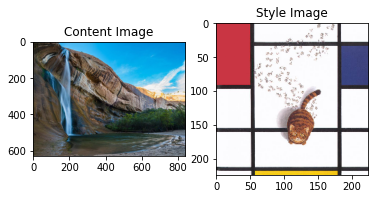

In [106]:
# # Choose content image
# content_image = load_img(os.path.join(content_path, '13.jpg'), target_size=(224, 224))
# # Choose a random style image
# style_image = random.choice(style_images)

content_image = load_img(content_path)
style_image = random.choice(style_images)

# Plot the chosen images
fig, axs = plt.subplots(1,2)
axs[0].imshow(content_image)
axs[0].set_title("Content Image")
axs[1].imshow(style_image[0])
axs[1].set_title("Style Image")


# Convert the images to tensors 
content_image = tf.convert_to_tensor(preprocess_image(content_image))
style_image = tf.convert_to_tensor(style_image)


In [8]:
def create_extractor(layers):
    """
    Returns model which extracts activations of the VGG model
    """
    vgg = VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False 
    
    outputs = [vgg.get_layer(layer).output for layer in layers]
    
    # Create the extractor model 
    model = tf.keras.Model([vgg.input], outputs)
    return model 

In [9]:
# Define the content and style layers 
content_layer = ['block4_conv2']

style_layers = [
    'block1_conv1', 
    'block2_conv1', 
    'block3_conv1',
    'block4_conv1', 
    'block5_conv1'
] 

In [10]:
def gram_matrix(input_tensor): 
    """
    Returns the gram matrix of the input tensor
    """
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [11]:
# Create an extractor model class
class ExtractorModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers): 
        super().__init__()
        self.extractor = create_extractor(content_layers + style_layers)
        self.style_layers = style_layers
        self.content_layers = content_layer
        self.extractor.trainable = False 
        self.num_content_layers = len(self.content_layers)
        self.num_style_layers = len(self.style_layers)
        
    def call(self, image):
        # Preprocess the image for the vgg model 
        image = image*255
        processed_image = preprocess_input(image)
        # Calculate the outputs
        activations = self.extractor(image)
        content_outputs, style_outputs = activations[:self.num_content_layers], activations[self.num_content_layers:]
        # Get the gram matrices of the style outputs
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        # Convert the outputs to dict 
        content_dict = {name: output for name, output in zip(self.content_layers, content_outputs)}
        style_dict = {name:output for name, output in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}
        
    

In [12]:
# Create a feature extractor
extractor = ExtractorModel(style_layers, content_layer)

80142336/80134624 [==============================] - 7s 0us/step


{'content': {'block4_conv2': <tf.Tensor: shape=(1, 28, 28, 512), dtype=float32, numpy=
  array([[[[1.4929207e+03, 0.0000000e+00, 0.0000000e+00, ...,
            4.0400790e+02, 1.6990210e+03, 3.6332062e+02],
           [1.5298866e+03, 0.0000000e+00, 0.0000000e+00, ...,
            0.0000000e+00, 1.6041866e+03, 9.0544629e+02],
           [1.5317520e+03, 0.0000000e+00, 0.0000000e+00, ...,
            0.0000000e+00, 1.3425288e+03, 6.1740680e+02],
           ...,
           [9.1855676e+02, 0.0000000e+00, 1.1821654e+01, ...,
            0.0000000e+00, 5.6223779e+02, 0.0000000e+00],
           [1.5962510e+03, 0.0000000e+00, 0.0000000e+00, ...,
            0.0000000e+00, 4.3821274e+02, 0.0000000e+00],
           [7.0530530e+02, 0.0000000e+00, 7.8273026e+01, ...,
            0.0000000e+00, 6.0265411e+02, 6.7753685e+01]],
  
          [[1.2061200e+03, 0.0000000e+00, 0.0000000e+00, ...,
            2.8660916e+02, 1.4664938e+03, 0.0000000e+00],
           [0.0000000e+00, 0.0000000e+00, 0.0000000e+

In [82]:
def generate_noise_image(source, parameters): 
    """
    Returns a randomly generated noisy image of the source
    """
    if 'noise_ratio' not in parameters: 
        parameters['noise_ratio'] = 0.6
        
    noise_sample = np.random.uniform(-20, 20, size=(parameters['height'], parameters['width'], parameters['channels']))
    # Take the weighted average of the sample image and source image
    noise_image = parameters['noise_ratio'] * noise_sample + (1-parameters['noise_ratio']) * content_image
    
    if 'asTensor' in parameters and parameters['asTensor'] is True: 
        return tf.convert_to_tensor(noise_image)
    else: 
        return noise_image

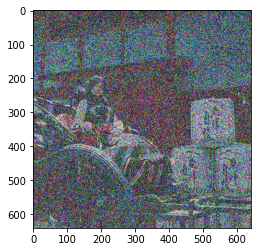

In [95]:
m, height, width, channels = content_image.get_shape()
# Initialize a random generated image
generated_image = tf.Variable(generate_noise_image(content_image, { 'noise_ratio': 0.0, 'height': height, 'width': width, 'channels': channels, 'asTensor': True}))

# Plot the generated image
plt.imshow(generated_image[0])

In [96]:
# Helper class to evaluate the loss of the current generated image
class Evaluator: 
    def __init__(self, style_image, content_image, weights): 
        # Set the content and style weights
        self.content_weight = weights['content']
        self.style_weight = weights['style']
        self.variation_weight = weights['variation']
        self.style_image = style_image
        self.content_image = content_image
        # Calculate the targets 
        self.style_targets = extractor(self.style_image)['style']
        self.content_targets = extractor(self.content_image)['content']
        
    def variation_cost(self, image):
        """
        Returns the variation cost of the image
        """
        diff_x = image[:,:,1:,:] - image[:,:,:-1,:]
        diff_y = image[:,1:,:,:] - image[:,:-1,:,:]

        variation_cost = tf.reduce_sum(tf.abs(diff_x)) + tf.reduce_sum(tf.abs(diff_y)) 
        return variation_cost
        
    def loss(self, image, activations): 
        """
        Returns the total loss of the generated image
        """
        
        # Compute the content cost of the image
        content_activations = activations['content']
        content_cost = tf.add_n([tf.reduce_sum(tf.square(tf.subtract(content_activations[name], self.content_targets[name]))) for name in content_layer])
        
        # Compute the style cost of the image
        style_outputs = activations['style']
        style_cost = tf.add_n([tf.reduce_sum(tf.square(tf.subtract(style_outputs[name], self.style_targets[name]))) for name in style_layers])
        # Multiply by the weight of each layer
        style_cost *= 1/len(style_layers)
        
        # Compute the variation cost
        variation_cost = self.variation_cost(image)
        
        return self.content_weight*content_cost + self.style_weight*style_cost + self.variation_weight*variation_cost

In [97]:
weights = { 'content': 1e5, 'style': 1e2, 'variation': 30} 

evaluator = Evaluator(style_image, content_image, weights)
# Extract the outputs of the generated image 
outputs = extractor(generated_image)

In [98]:
# Create an ADAM optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [99]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [100]:
# Define the training step
@tf.function()
def train_step(image): 
    with tf.GradientTape() as tape: 
        outputs = extractor.call(image)
        loss = evaluator.loss(image, outputs)
    grads = tape.gradient(loss, image)
    # Update the generated image
    opt.apply_gradients([(grads, image)])
    image.assign(clip_0_1(image))
        

In [101]:
def train_model(epochs, iters): 
    for i in range(epochs): 
        print(f'Epoch {i}')
        for j in range(iters): 
            if j%50 == 0: print(f'  Iteration {j}')
            train_step(generated_image)

train_model(5, 100)

Epoch 0
  Iteration 0
  Iteration 50
Epoch 1
  Iteration 0
  Iteration 50
Epoch 2
  Iteration 0
  Iteration 50
Epoch 3
  Iteration 0
  Iteration 50
Epoch 4
  Iteration 0
  Iteration 50


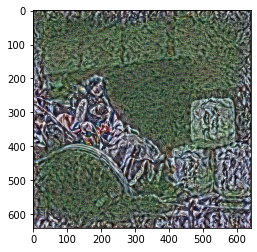

In [107]:
plt.imshow(generated_image.numpy()[0])